# Feature Engineering
## Setup

In [150]:
EXPORT_PATH = "../data/processed/"
ASSETS_PATH = "../assets/plots/eda/"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Plot Style ===
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
def plot_histogram(
    data, column, bins=30, kde=True, figsize=(10, 4), 
    title=None, xlabel=None, ylabel="Number of Patients", 
    save_path=None
):
    plt.figure(figsize=figsize)
    sns.histplot(data[column], bins=bins, kde=kde)
    plt.title(title if title else f"{column} Distribution")
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [151]:
# === Load dataset ===
df_final = pd.read_csv(os.path.join(EXPORT_PATH, "df_final_static.csv"))

# === Confirm structure ===
print(df_final.shape)
df_final.head()

(3685, 16)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,AGE,GENDER,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,FIRST_CAREUNIT,LOS,HOSPITAL_EXPIRE_FLAG,INTIME_HOUR,INTIME_WEEKDAY,ADMITTIME_HOUR,ADMITTIME_WEEKDAY,INTIME
0,269,106296,206613,40,M,EMERGENCY,EMERGENCY ROOM ADMIT,Medicaid,MICU,3.2788,0,11,0,11,0,2170-11-05 11:05:29
1,275,129886,219649,82,M,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CCU,7.1314,1,11,6,3,5,2170-10-07 11:28:53
2,292,179726,222505,57,F,URGENT,TRANSFER FROM HOSP/EXTRAM,Private,MICU,0.8854,1,18,3,18,3,2103-09-27 18:29:30
3,305,194340,217232,76,F,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,SICU,2.4370,1,12,5,18,5,2129-09-03 12:31:31
4,323,143334,264375,57,M,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,MICU,3.0252,0,15,3,15,3,2120-01-11 15:48:28


## Adding Dynamic Features (Temporal Aggregation)

In [152]:
# Define ITEMIDs per MIMIC-III documentation for vital signs
vital_items = {
    "Heart Rate": [211, 220045],
    "Systolic BP": [51, 455, 220179, 220050],
    "Diastolic BP": [8368, 8441, 220180, 220051],
    "Mean BP": [52, 456, 220052],
    "Respiratory Rate": [618, 220210],
    "Temperature": [678, 223761],
    "SpO2": [646, 220277],
    "Glucose": [807, 220621]
}

itemid_to_label = {item: label for label, items in vital_items.items() for item in items}

In [153]:
# Load CHARTEVENTS and cohort ICU
chartevents = pd.read_csv(EXPORT_PATH + "chartevents_sepsis.csv", parse_dates=["CHARTTIME"])
cohort_icu = pd.read_csv(EXPORT_PATH + "df_final_static.csv")

# Join CHARTEVENTS with cohort ICU
first24h = chartevents.merge(cohort_icu[["ICUSTAY_ID", "INTIME"]], on="ICUSTAY_ID", how="inner")
first24h["HOURS_FROM_INTIME"] = (first24h["CHARTTIME"] - pd.to_datetime(first24h["INTIME"])).dt.total_seconds() / 3600
first24h = first24h[(first24h["HOURS_FROM_INTIME"] >= 0) & (first24h["HOURS_FROM_INTIME"] <= 24)]

# Filter valid ITEMIDs and non-null VALUENUM
first24h = first24h[first24h["ITEMID"].isin(itemid_to_label)]
first24h = first24h[first24h["VALUENUM"].notnull()]
first24h["VITAL_TYPE"] = first24h["ITEMID"].map(itemid_to_label)


/var/folders/0j/nhv3j29j5bngf6nym9kpvhl80000gn/T/ipykernel_43968/3589101290.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  chartevents = pd.read_csv(EXPORT_PATH + "chartevents_sepsis.csv", parse_dates=["CHARTTIME"])


In [154]:
# Aggregation per ICUSTAY_ID and VITAL_TYPE
vital_features = []

for label in vital_items.keys():
    temp = first24h[first24h["VITAL_TYPE"] == label]
    stats = temp.groupby("ICUSTAY_ID")["VALUENUM"].agg(["mean", "std", "min", "max", "count", "skew"]).reset_index()
    stats.columns = ["ICUSTAY_ID"] + [f"{label.upper().replace(' ', '_')}_{stat.upper()}" for stat in stats.columns[1:]]
    vital_features.append(stats)

# Merge all together
from functools import reduce
df_vitals = reduce(lambda left, right: pd.merge(left, right, on="ICUSTAY_ID", how="outer"), vital_features)


In [155]:
# Merge dynamic features into df_final
df_final = pd.read_csv(EXPORT_PATH + "df_final_static.csv")
df_enriched = df_final.merge(df_vitals, on="ICUSTAY_ID", how="left")

# Save to disk
df_enriched.to_csv(EXPORT_PATH + "df_final_enriched.csv", index=False)
print(f"Final enriched dataset shape: {df_enriched.shape}")

Final enriched dataset shape: (3685, 64)


## Data Cleaning

In [156]:
# Print missing data statistics greater than 10%
missing_data = df_enriched.isnull().sum().sort_values(ascending=False) / len(df_enriched)
print(missing_data)
print(len(missing_data))


GLUCOSE_SKEW          0.808412
MEAN_BP_SKEW          0.797829
MEAN_BP_STD           0.794301
MEAN_BP_COUNT         0.790231
MEAN_BP_MIN           0.790231
                        ...   
FIRST_CAREUNIT        0.000000
GENDER                0.000000
INSURANCE             0.000000
ADMISSION_LOCATION    0.000000
SUBJECT_ID            0.000000
Length: 64, dtype: float64
64


In [157]:
df = df_enriched.copy()
# Remove features with more than 60% missing data
features_to_remove = missing_data[missing_data > 0.49].index.tolist()
# Drop features with more than 60% missing data
df.drop(columns=features_to_remove, inplace=True)
# Print the number of features removed
len(features_to_remove)

26

In [158]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
import pandas as pd

# Filtra solo colonne numeriche
df_numeric = df.select_dtypes(include='number')

# Imputazione iterativa
iter_imputer = IterativeImputer()
df_imputed = pd.DataFrame(
    iter_imputer.fit_transform(df_numeric),
    columns=df_numeric.columns
)

# Se vuoi reinserire le colonne non numeriche:
df_final = pd.concat([df_imputed, df.drop(columns=df_numeric.columns)], axis=1)

df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3685 entries, 0 to 3684
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SUBJECT_ID              3685 non-null   float64
 1   HADM_ID                 3685 non-null   float64
 2   ICUSTAY_ID              3685 non-null   float64
 3   AGE                     3685 non-null   float64
 4   LOS                     3685 non-null   float64
 5   HOSPITAL_EXPIRE_FLAG    3685 non-null   float64
 6   INTIME_HOUR             3685 non-null   float64
 7   INTIME_WEEKDAY          3685 non-null   float64
 8   ADMITTIME_HOUR          3685 non-null   float64
 9   ADMITTIME_WEEKDAY       3685 non-null   float64
 10  HEART_RATE_MEAN         3685 non-null   float64
 11  HEART_RATE_STD          3685 non-null   float64
 12  HEART_RATE_MIN          3685 non-null   float64
 13  HEART_RATE_MAX          3685 non-null   float64
 14  HEART_RATE_COUNT        3685 non-null   

## Scaling
### Setup Columns List

In [159]:
# Exclude identifier and non-numeric columns
exclude_cols = [
    "SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "INTIME", "GENDER",
    "ADMISSION_TYPE", "ADMISSION_LOCATION", "INSURANCE", "FIRST_CAREUNIT",
    'HOSPITAL_EXPIRE_FLAG'
]
numeric_cols = [col for col in df.columns if col not in exclude_cols and np.issubdtype(df[col].dtype, np.number)]
numeric_cols

['AGE',
 'LOS',
 'INTIME_HOUR',
 'INTIME_WEEKDAY',
 'ADMITTIME_HOUR',
 'ADMITTIME_WEEKDAY',
 'HEART_RATE_MEAN',
 'HEART_RATE_STD',
 'HEART_RATE_MIN',
 'HEART_RATE_MAX',
 'HEART_RATE_COUNT',
 'HEART_RATE_SKEW',
 'RESPIRATORY_RATE_MEAN',
 'RESPIRATORY_RATE_STD',
 'RESPIRATORY_RATE_MIN',
 'RESPIRATORY_RATE_MAX',
 'RESPIRATORY_RATE_COUNT',
 'RESPIRATORY_RATE_SKEW',
 'SPO2_MEAN',
 'SPO2_STD',
 'SPO2_MIN',
 'SPO2_MAX',
 'SPO2_COUNT',
 'SPO2_SKEW',
 'GLUCOSE_MEAN',
 'GLUCOSE_MIN',
 'GLUCOSE_MAX',
 'GLUCOSE_COUNT']

### Analyze AGE Distribution

array([[<Axes: title={'center': 'AGE'}>]], dtype=object)

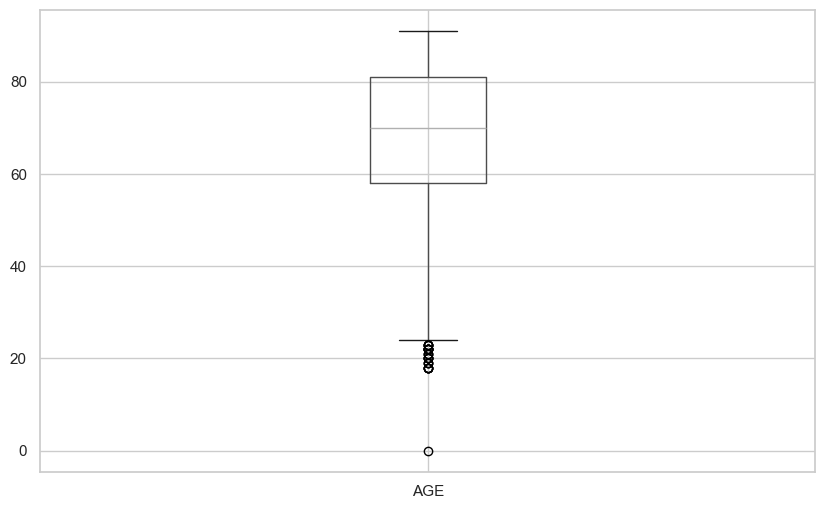

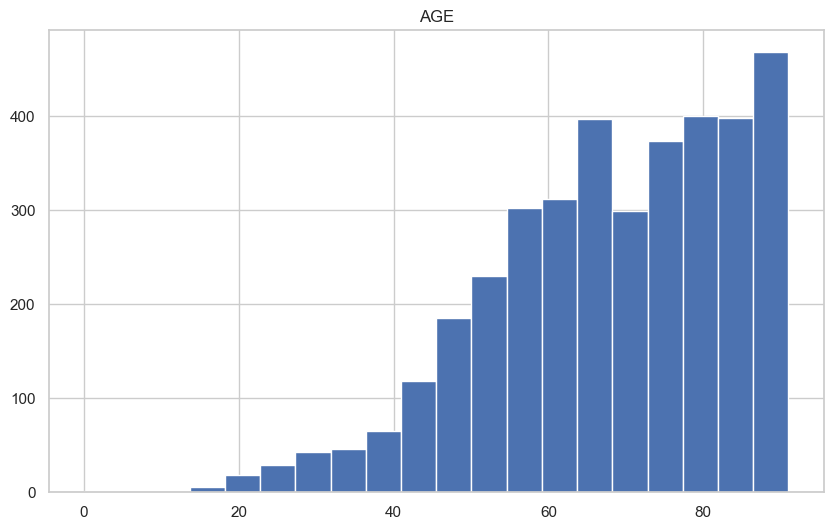

In [160]:
df[['AGE']].boxplot() # Boxplot
df[['AGE']].hist(bins=20) # Histogram

In [161]:
# Utilizzo MinMaxScaler per normalizzare la colonna 'AGE'
from sklearn.preprocessing import MinMaxScaler

minmaxscaler = MinMaxScaler().fit(df[['AGE']]) 
df['AGE']= minmaxscaler.transform(df[['AGE']]) 

df['AGE'].head()

0    0.439560
1    0.901099
2    0.626374
3    0.835165
4    0.626374
Name: AGE, dtype: float64

### LOS

array([[<Axes: title={'center': 'LOS'}>]], dtype=object)

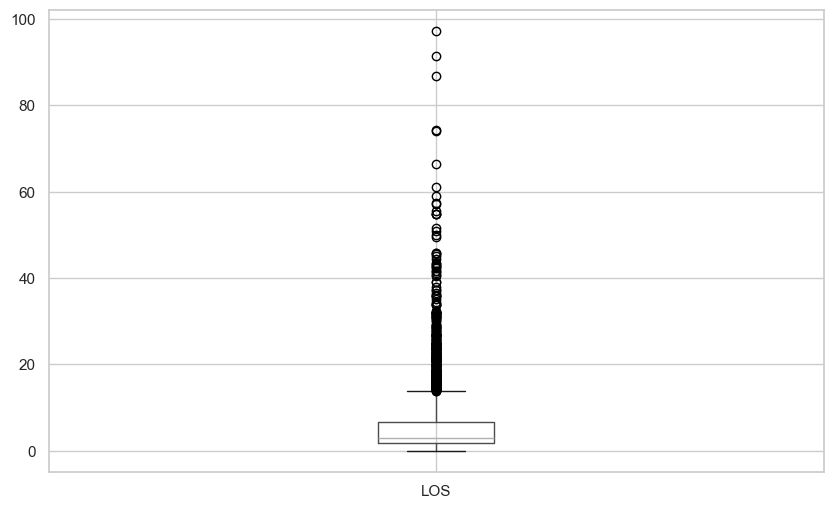

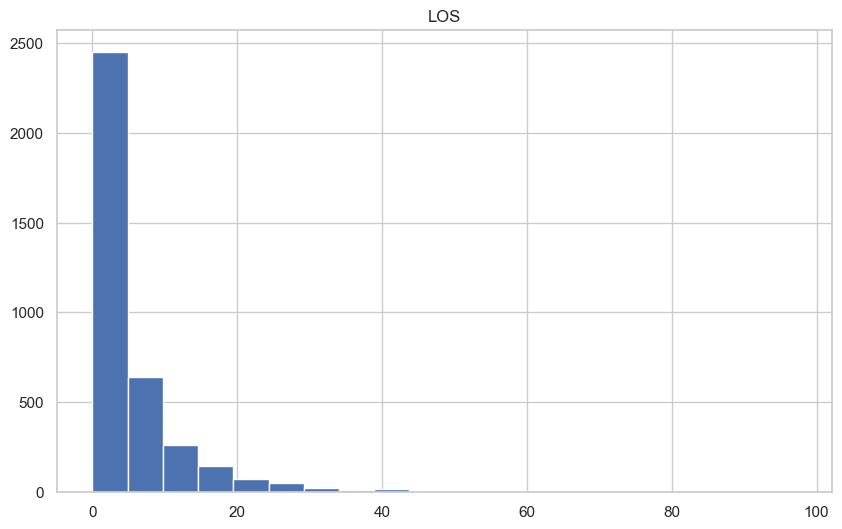

In [162]:
df[['LOS']].boxplot() # Boxplot
df[['LOS']].hist(bins=20) # Histogram

In [163]:
# Troppi outliers, quindi utilizziamo RobustScaler
from sklearn.preprocessing import RobustScaler
rb_scaler = RobustScaler().fit(df[['LOS']])
df['LOS'] = rb_scaler.transform(df[['LOS']])

df['LOS'].head()

0    0.053155
1    0.842606
2   -0.437286
3   -0.119342
4    0.001189
Name: LOS, dtype: float64

array([[<Axes: title={'center': 'INTIME_WEEKDAY'}>]], dtype=object)

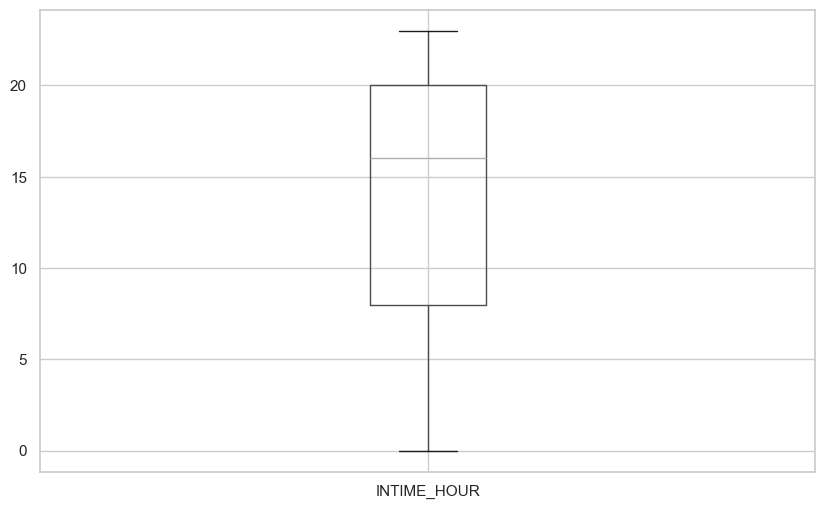

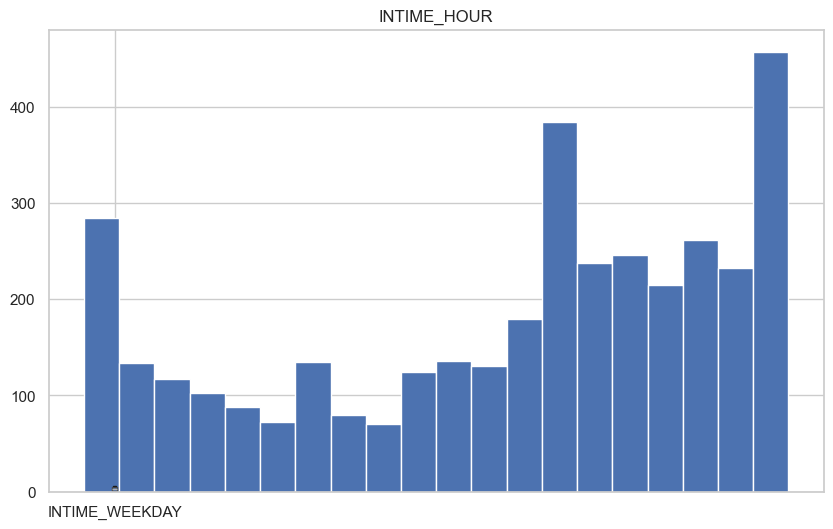

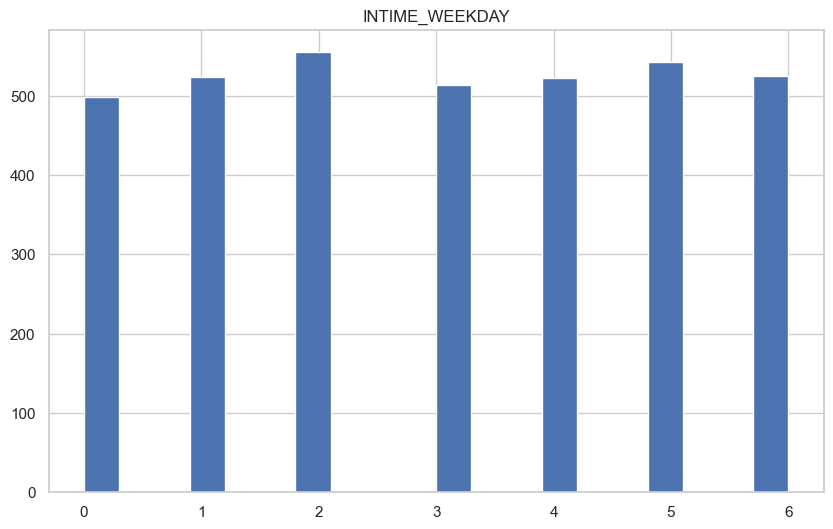

In [164]:
df[['INTIME_HOUR']].boxplot()
df[['INTIME_HOUR']].hist(bins=20)

df[['INTIME_WEEKDAY']].boxplot()
df[['INTIME_WEEKDAY']].hist(bins=20)

In [165]:
df['INTIME_HOUR'] = minmaxscaler.fit_transform(df[['INTIME_HOUR']])
df['INTIME_WEEKDAY'] = minmaxscaler.fit_transform(df[['INTIME_WEEKDAY']])

df[['INTIME_HOUR', 'INTIME_WEEKDAY']].head()

,INTIME_HOUR,INTIME_WEEKDAY
0,0.478261,0.000000
1,0.478261,1.000000
2,0.782609,0.500000
3,0.521739,0.833333
4,0.652174,0.500000


array([[<Axes: title={'center': 'ADMITTIME_WEEKDAY'}>]], dtype=object)

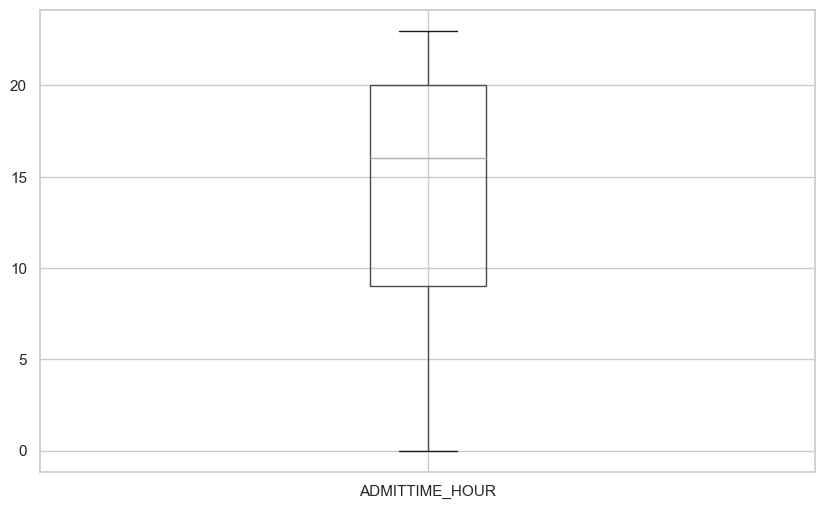

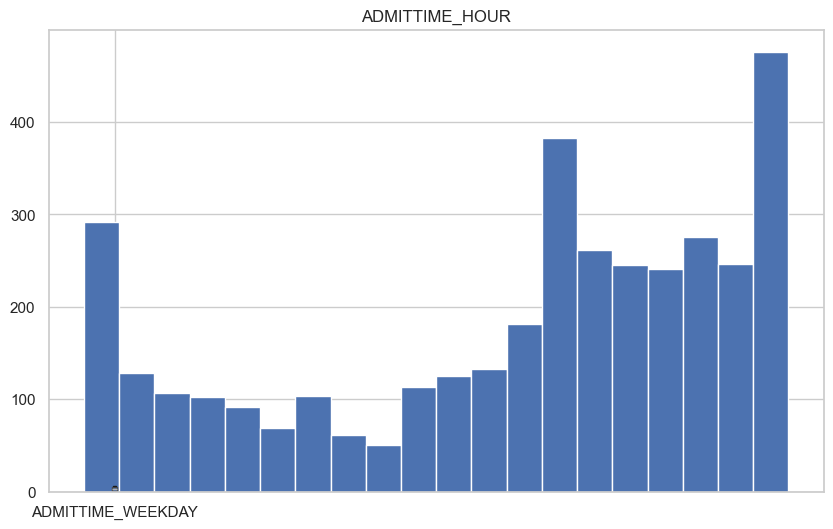

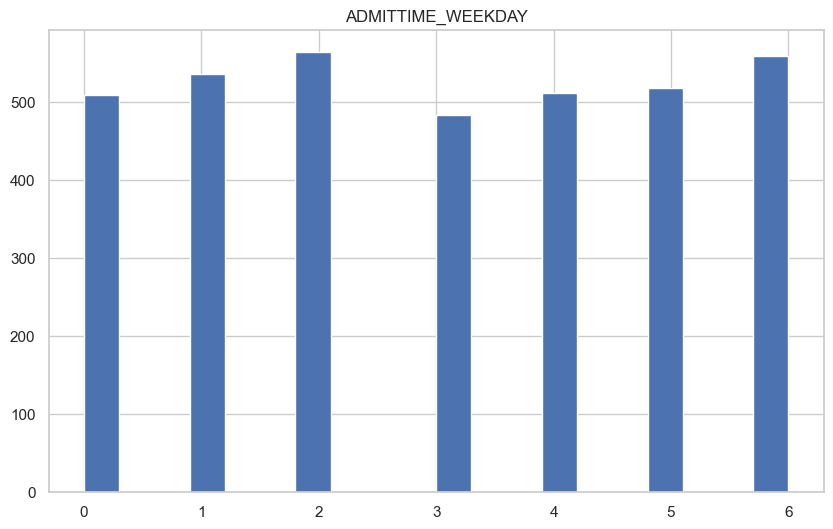

In [166]:
df[['ADMITTIME_HOUR']].boxplot()
df[['ADMITTIME_HOUR']].hist(bins=20)

df[['ADMITTIME_WEEKDAY']].boxplot()
df[['ADMITTIME_WEEKDAY']].hist(bins=20)

In [167]:
df['ADMITTIME_HOUR'] = minmaxscaler.fit_transform(df[['ADMITTIME_HOUR']])
df['ADMITTIME_WEEKDAY'] = minmaxscaler.fit_transform(df[['ADMITTIME_WEEKDAY']])

df[['ADMITTIME_HOUR', 'ADMITTIME_WEEKDAY']].head()

,ADMITTIME_HOUR,ADMITTIME_WEEKDAY
0,0.478261,0.000000
1,0.130435,0.833333
2,0.782609,0.500000
3,0.782609,0.833333
4,0.652174,0.500000


array([[<Axes: title={'center': 'HEART_RATE_SKEW'}>]], dtype=object)

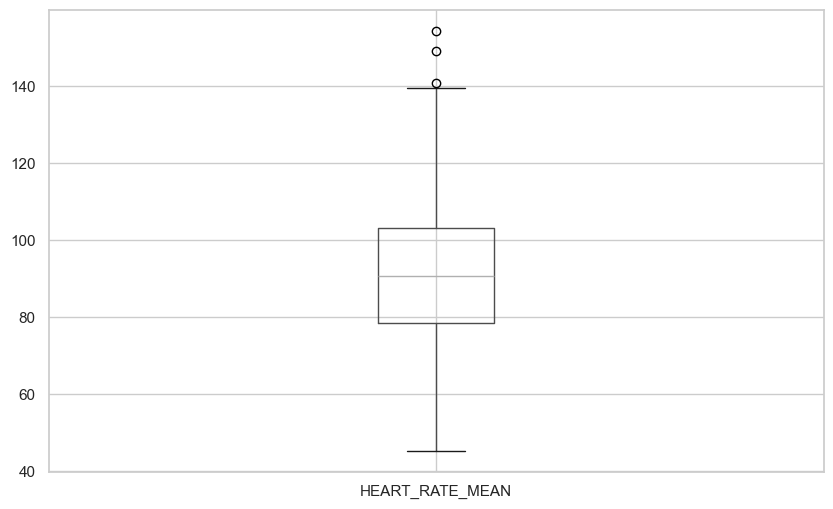

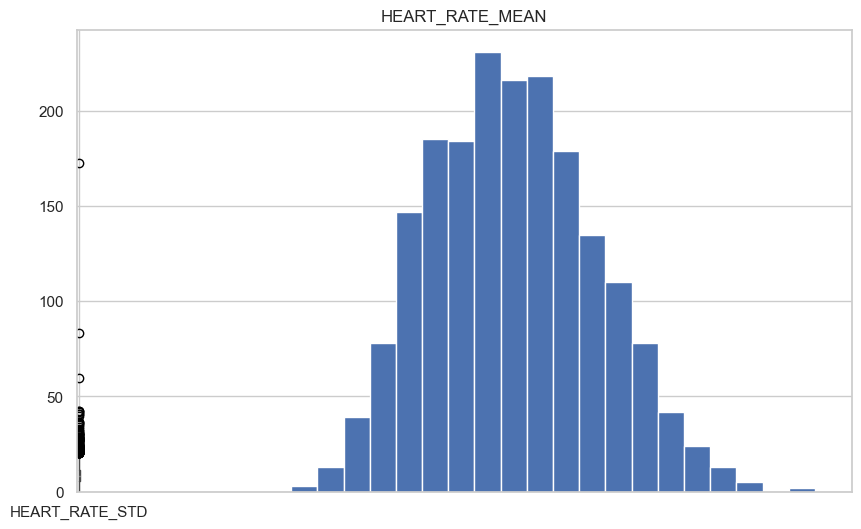

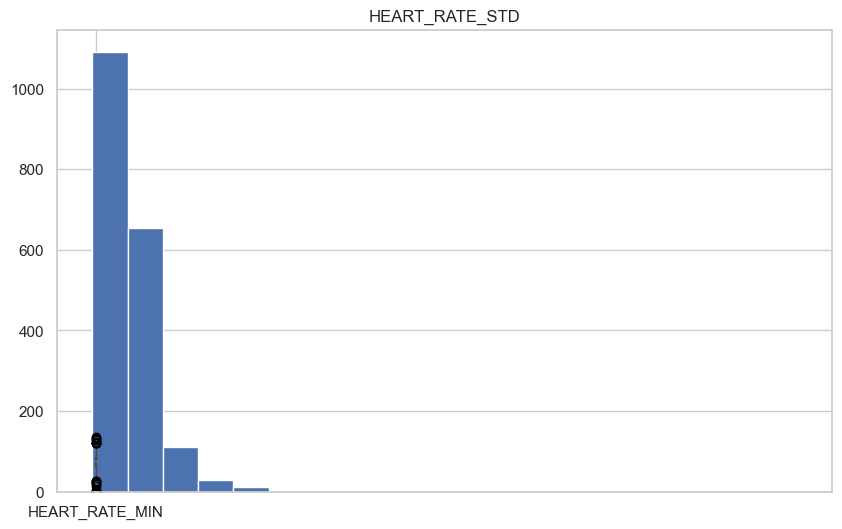

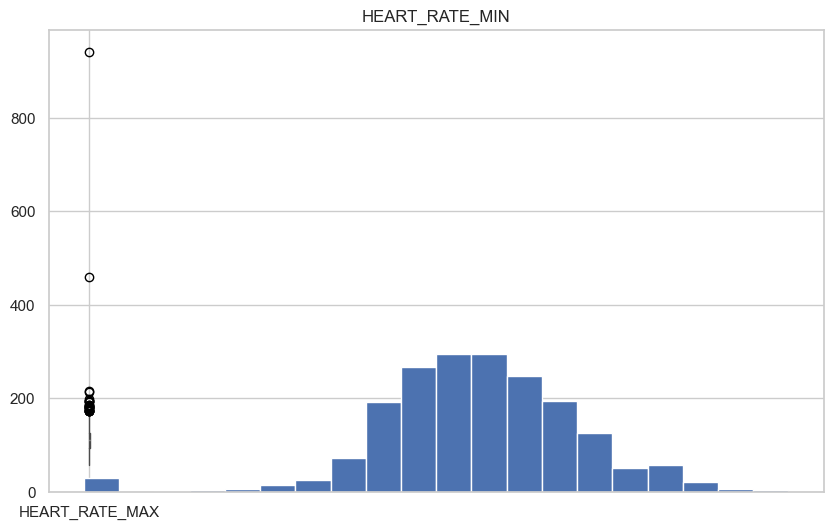

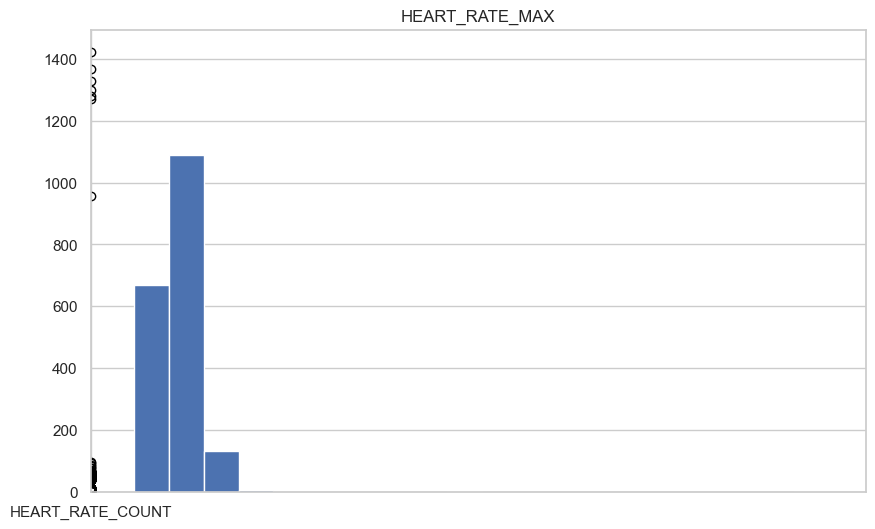

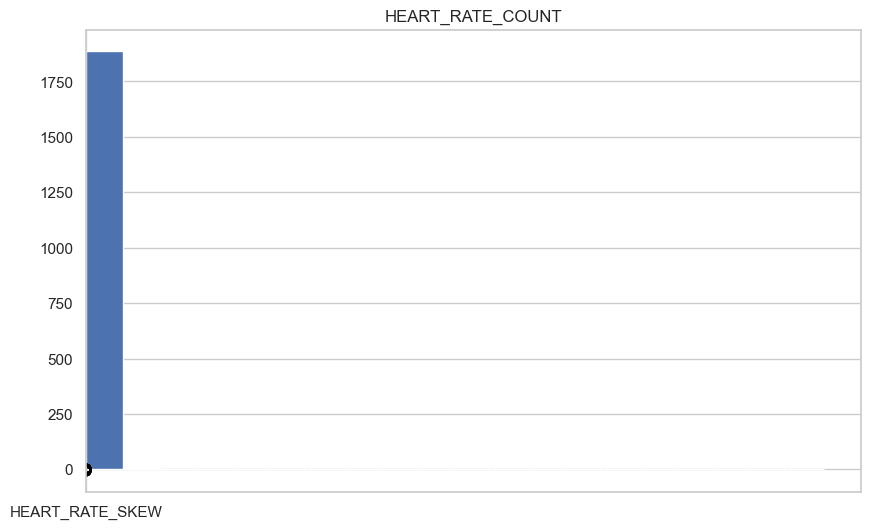

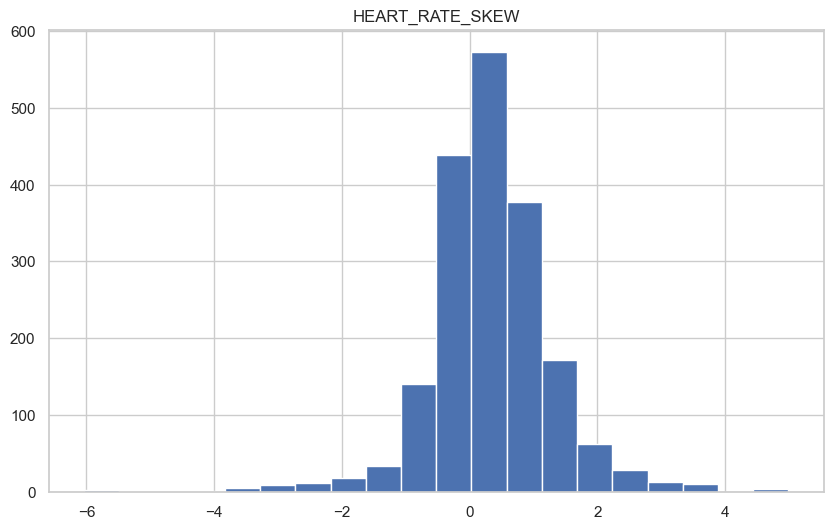

In [168]:
df[['HEART_RATE_MEAN']].boxplot()
df[['HEART_RATE_MEAN']].hist(bins=20)

df[['HEART_RATE_STD']].boxplot()
df[['HEART_RATE_STD']].hist(bins=20)

df[['HEART_RATE_MIN']].boxplot()
df[['HEART_RATE_MIN']].hist(bins=20)

df[['HEART_RATE_MAX']].boxplot()
df[['HEART_RATE_MAX']].hist(bins=20)

df[['HEART_RATE_COUNT']].boxplot()
df[['HEART_RATE_COUNT']].hist(bins=20)

df[['HEART_RATE_SKEW']].boxplot()
df[['HEART_RATE_SKEW']].hist(bins=20)

In [169]:
# Scaling Heart Rate features
heart_rate_features = [
    'HEART_RATE_MEAN', 'HEART_RATE_STD', 'HEART_RATE_MIN',
    'HEART_RATE_MAX', 'HEART_RATE_COUNT', 'HEART_RATE_SKEW'
]
for feature in heart_rate_features:
    df[feature] = minmaxscaler.fit_transform(df[[feature]])

df[heart_rate_features].head()

,HEART_RATE_MEAN,HEART_RATE_STD,HEART_RATE_MIN,HEART_RATE_MAX,HEART_RATE_COUNT,HEART_RATE_SKEW
0,0.715383,0.080933,0.733333,0.102825,0.021082,0.524927
1,0.151088,0.054718,0.370370,0.038418,0.015460,0.721928
2,0.368821,0.135338,0.000000,0.061017,0.017569,0.284040
3,0.468597,0.059596,0.600000,0.064407,0.018271,0.544127
4,0.289943,0.027484,0.511111,0.039548,0.016163,0.624800


array([[<Axes: title={'center': 'RESPIRATORY_RATE_SKEW'}>]], dtype=object)

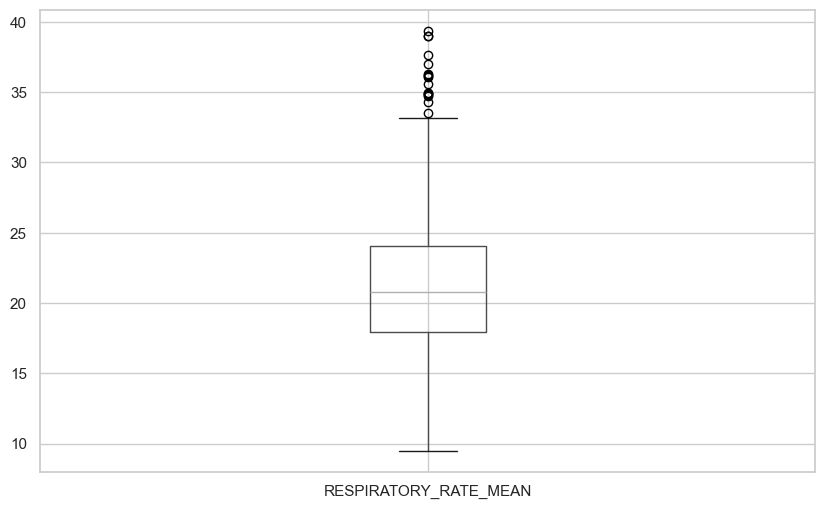

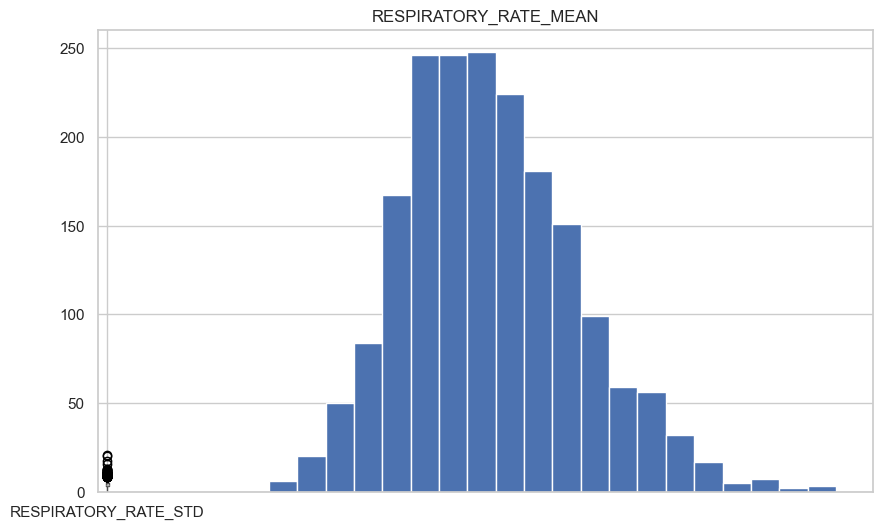

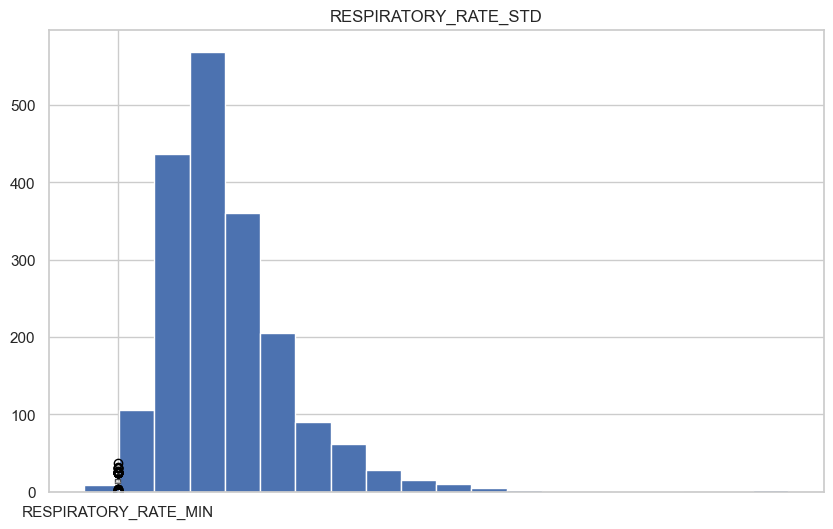

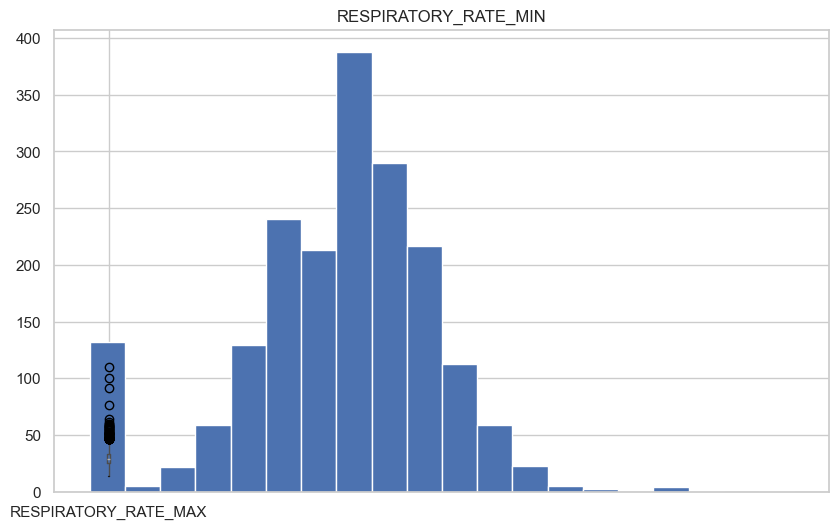

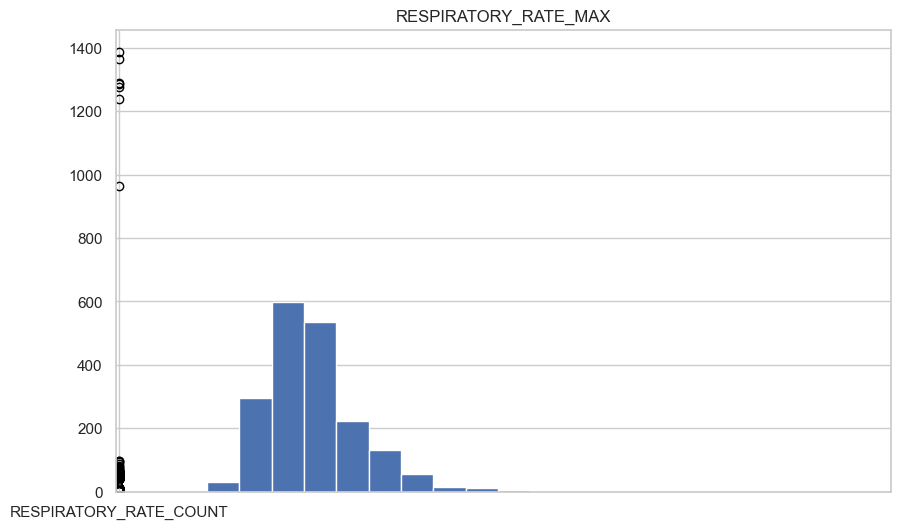

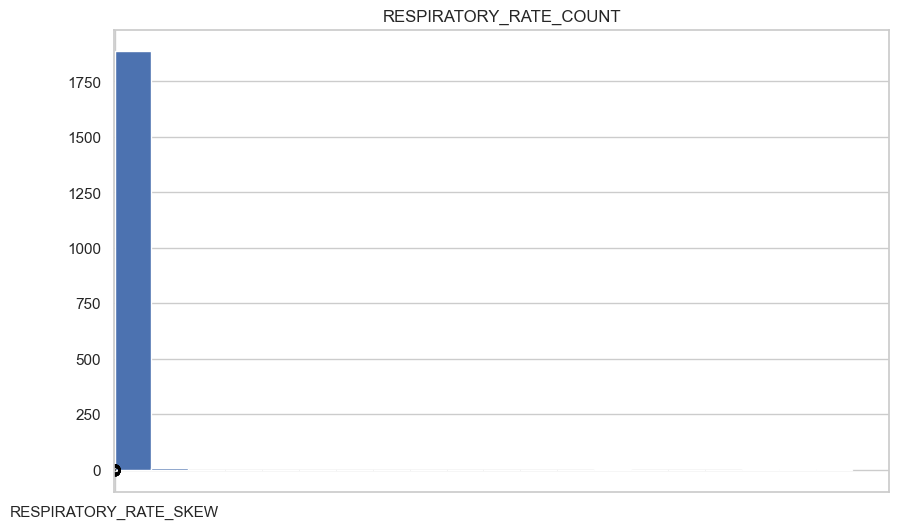

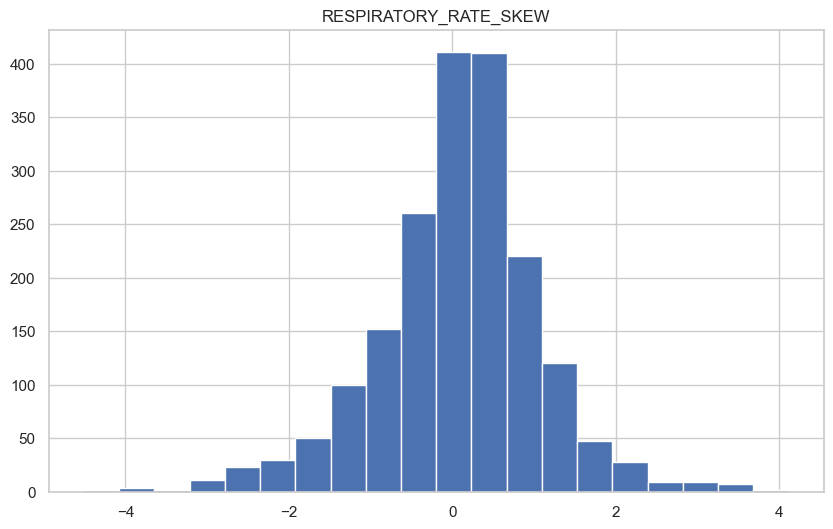

In [170]:
df[['RESPIRATORY_RATE_MEAN']].boxplot()
df[['RESPIRATORY_RATE_MEAN']].hist(bins=20)

df[['RESPIRATORY_RATE_STD']].boxplot()
df[['RESPIRATORY_RATE_STD']].hist(bins=20)

df[['RESPIRATORY_RATE_MIN']].boxplot()
df[['RESPIRATORY_RATE_MIN']].hist(bins=20)

df[['RESPIRATORY_RATE_MAX']].boxplot()
df[['RESPIRATORY_RATE_MAX']].hist(bins=20)

df[['RESPIRATORY_RATE_COUNT']].boxplot()
df[['RESPIRATORY_RATE_COUNT']].hist(bins=20)

df[['RESPIRATORY_RATE_SKEW']].boxplot()
df[['RESPIRATORY_RATE_SKEW']].hist(bins=20)

In [171]:
# StandardScaler for Respiratory Rate features
respiratory_rate_features = [
    'RESPIRATORY_RATE_MEAN', 'RESPIRATORY_RATE_STD', 'RESPIRATORY_RATE_MIN',
    'RESPIRATORY_RATE_MAX', 'RESPIRATORY_RATE_COUNT', 'RESPIRATORY_RATE_SKEW'
]
for feature in respiratory_rate_features:
    df[feature] = minmaxscaler.fit_transform(df[[feature]])

df[respiratory_rate_features].head()

,RESPIRATORY_RATE_MEAN,RESPIRATORY_RATE_STD,RESPIRATORY_RATE_MIN,RESPIRATORY_RATE_MAX,RESPIRATORY_RATE_COUNT,RESPIRATORY_RATE_SKEW
0,0.519026,0.294160,0.324324,0.250000,0.020908,0.502366
1,0.153729,0.157775,0.324324,0.093750,0.015141,0.707825
2,0.584709,0.394761,0.000000,0.187500,0.018025,0.173120
3,0.263544,0.212316,0.324324,0.114583,0.018745,0.573749
4,0.479959,0.257996,0.297297,0.208333,0.016583,0.510411


array([[<Axes: title={'center': 'SPO2_SKEW'}>]], dtype=object)

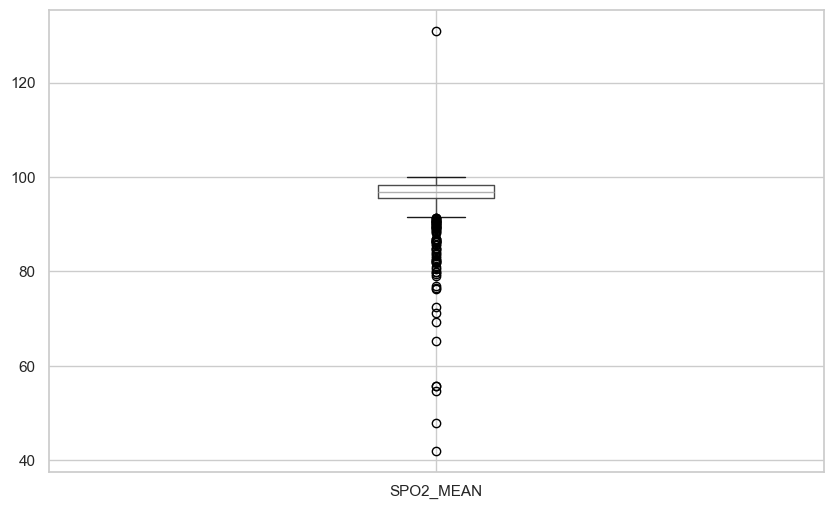

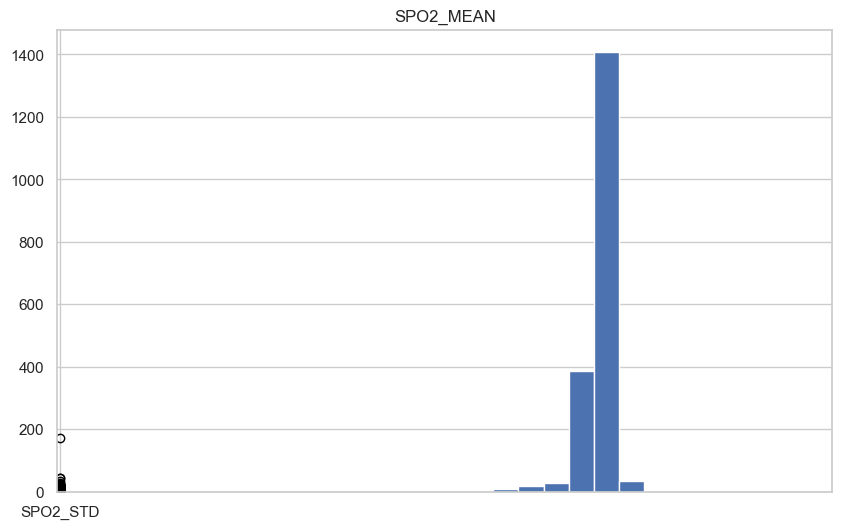

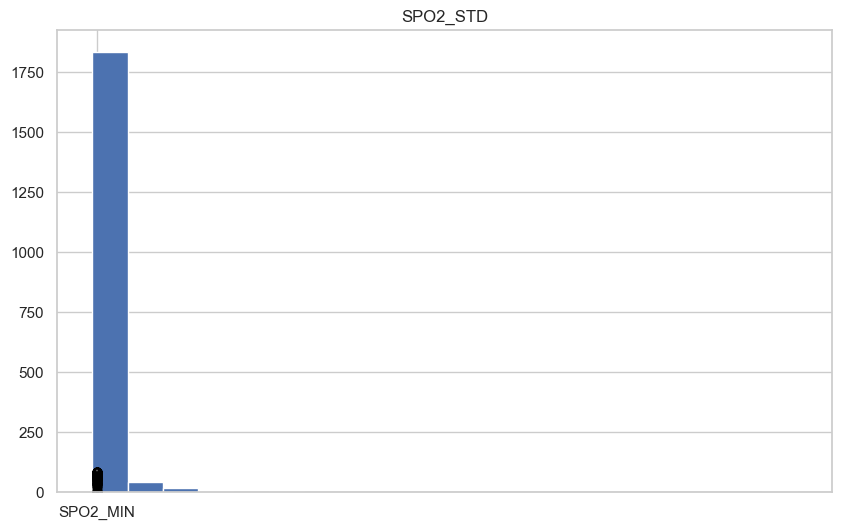

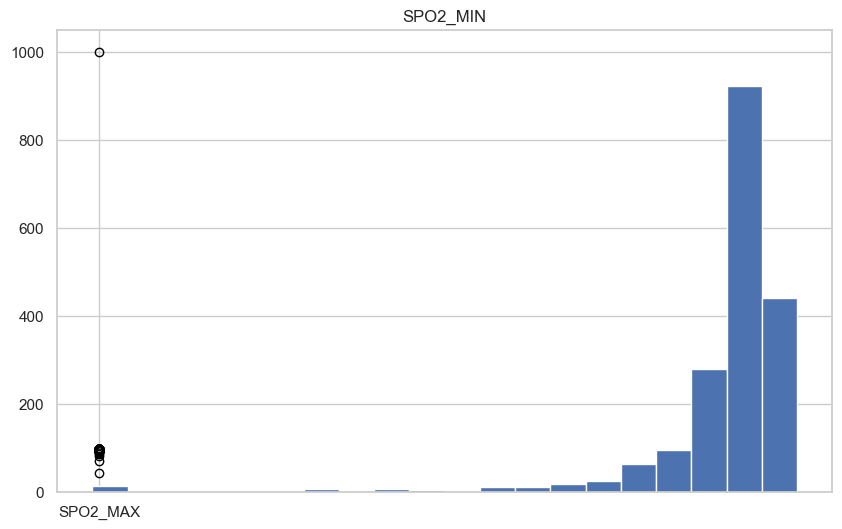

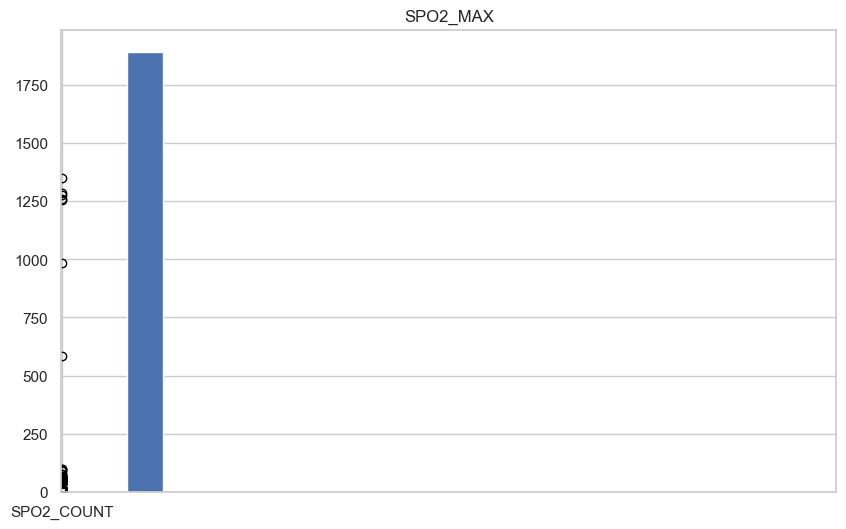

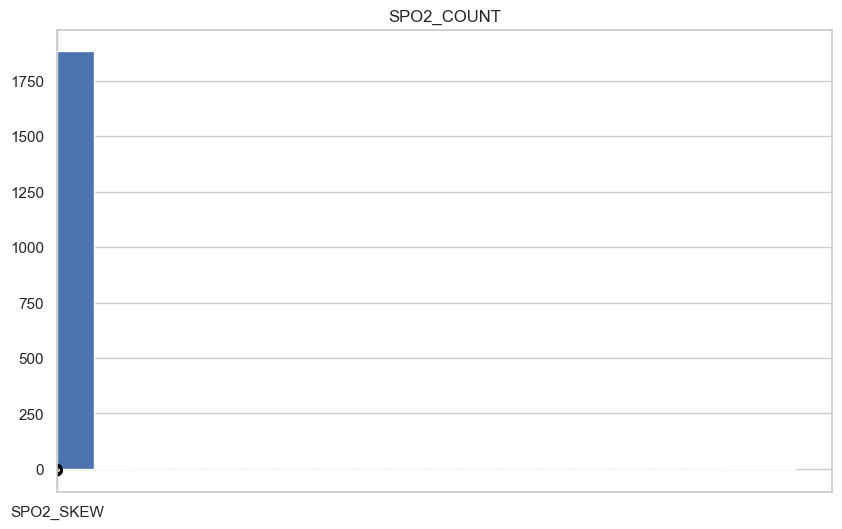

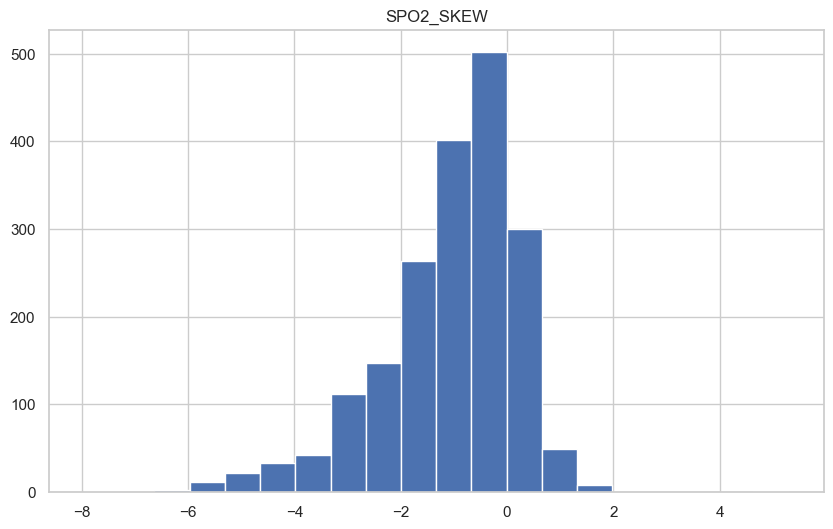

In [172]:
df[['SPO2_MEAN']].boxplot()
df[['SPO2_MEAN']].hist(bins=20)

df[['SPO2_STD']].boxplot()
df[['SPO2_STD']].hist(bins=20)

df[['SPO2_MIN']].boxplot()
df[['SPO2_MIN']].hist(bins=20)

df[['SPO2_MAX']].boxplot()
df[['SPO2_MAX']].hist(bins=20)

df[['SPO2_COUNT']].boxplot()
df[['SPO2_COUNT']].hist(bins=20)

df[['SPO2_SKEW']].boxplot()
df[['SPO2_SKEW']].hist(bins=20)

In [173]:
# RobustScaler for SpO2 features
spo2_features = [
    'SPO2_MEAN', 'SPO2_STD', 'SPO2_MIN',
    'SPO2_MAX', 'SPO2_COUNT', 'SPO2_SKEW'
]
for feature in spo2_features:
    df[feature] = minmaxscaler.fit_transform(df[[feature]])

df[spo2_features].head()

,SPO2_MEAN,SPO2_STD,SPO2_MIN,SPO2_MAX,SPO2_COUNT,SPO2_SKEW
0,0.619527,0.016661,0.91,0.060543,0.020725,0.542105
1,0.649438,0.003614,0.98,0.060543,0.014064,0.382572
2,0.066479,0.255684,0.00,0.058455,0.008142,0.585254
3,0.643362,0.005300,0.97,0.060543,0.019245,0.507010
4,0.630562,0.013488,0.92,0.060543,0.017765,0.485320


array([[<Axes: title={'center': 'GLUCOSE_COUNT'}>]], dtype=object)

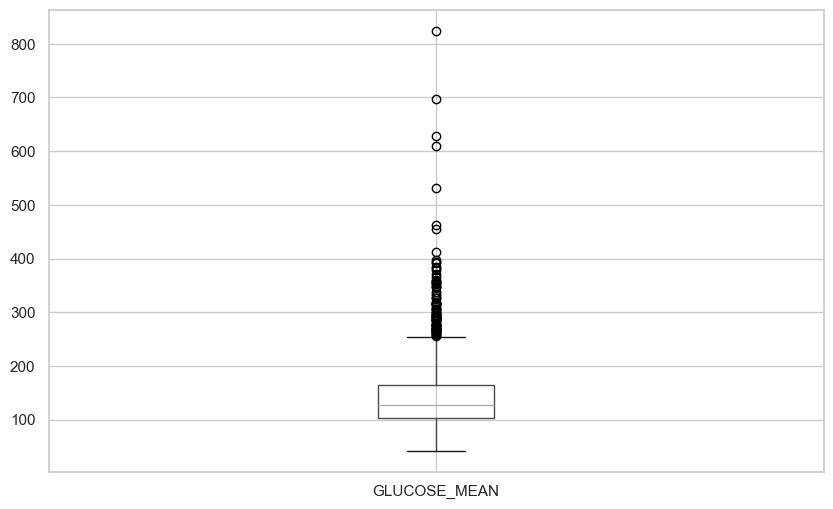

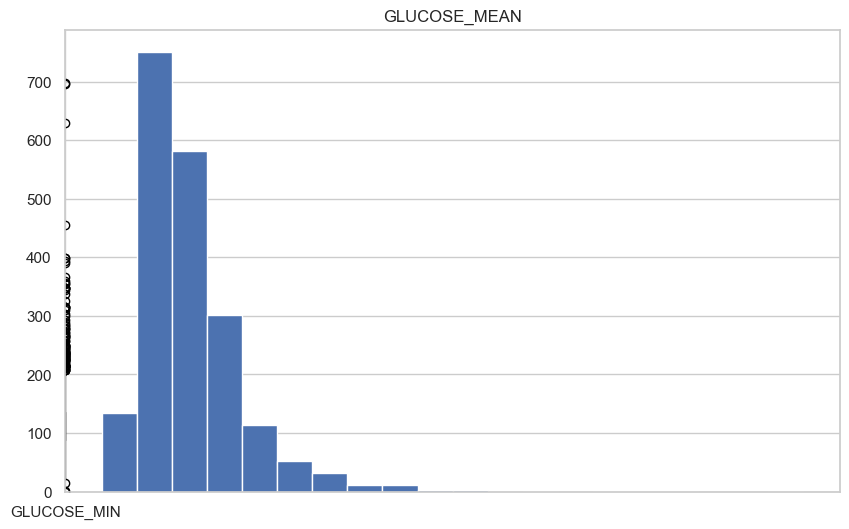

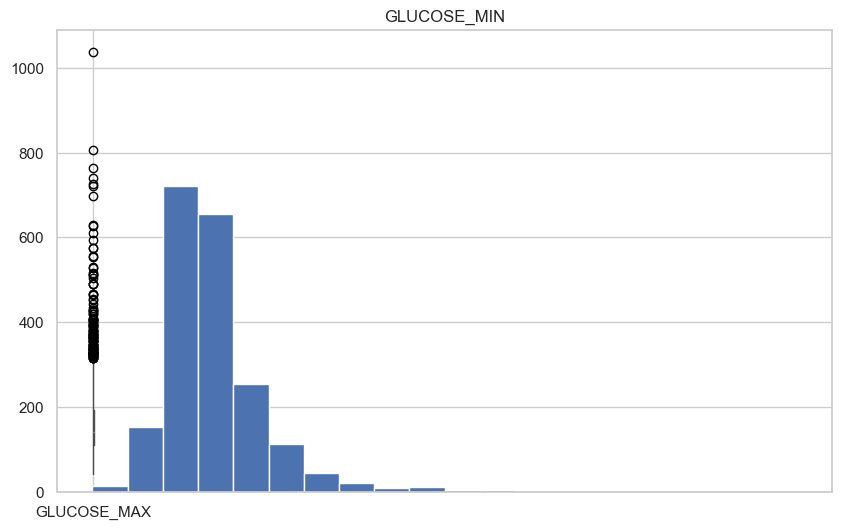

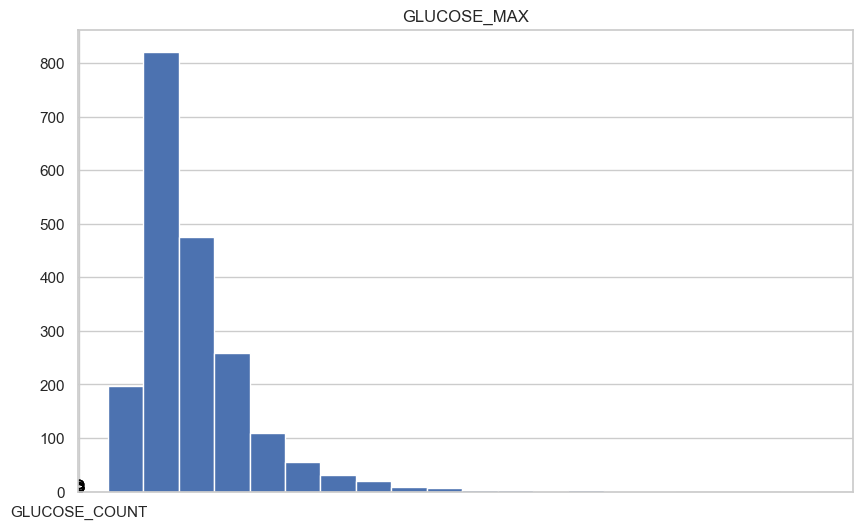

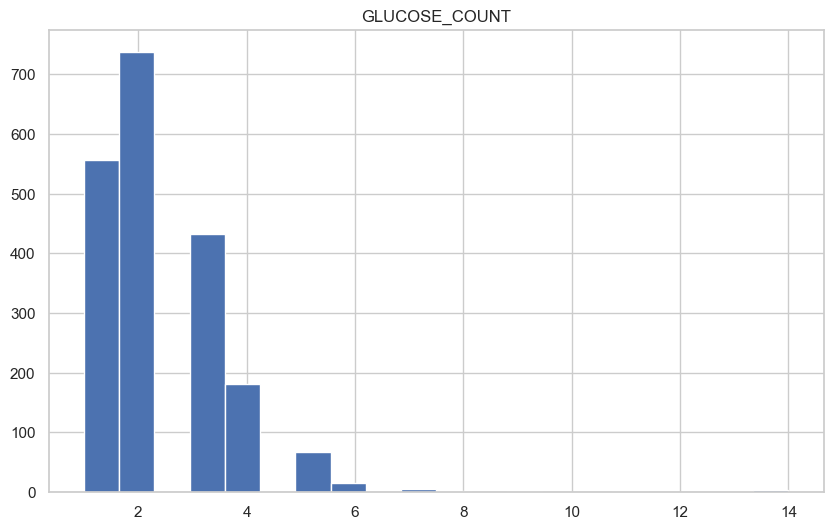

In [174]:
df[['GLUCOSE_MEAN']].boxplot()
df[['GLUCOSE_MEAN']].hist(bins=20)

df[['GLUCOSE_MIN']].boxplot()
df[['GLUCOSE_MIN']].hist(bins=20)

df[['GLUCOSE_MAX']].boxplot()
df[['GLUCOSE_MAX']].hist(bins=20)

df[['GLUCOSE_COUNT']].boxplot()
df[['GLUCOSE_COUNT']].hist(bins=20)

In [175]:
glucose_features = [
    'GLUCOSE_MEAN', 'GLUCOSE_MIN', 'GLUCOSE_MAX', 'GLUCOSE_COUNT'
]
for feature in glucose_features:
    df[feature] = rb_scaler.fit_transform(df[[feature]])

df[glucose_features].head()

,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_COUNT
0,0.680926,1.255319,0.344615,-0.5
1,-0.246118,-0.361702,-0.110769,0.0
2,NaN,NaN,NaN,NaN
3,1.747436,2.638298,1.144615,-0.5
4,0.704366,-0.723404,2.929231,6.0


## Encoding

In [176]:
df = df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])

In [177]:
df = pd.get_dummies(df, columns=[
    'INTIME_HOUR', 'INTIME_WEEKDAY', 'ADMITTIME_HOUR', 'ADMITTIME_WEEKDAY'
], drop_first=True)

In [178]:
assert df.select_dtypes(include='object').empty

AssertionError: 

## Investigazione della Collinearità

In [ ]:
# Calcola la matrice di correlazione solo tra variabili numeriche
correlation_matrix = df.corr(numeric_only=True)

# Estrai la colonna di correlazione con LOS, escludendo la self-correlation
los_corr = correlation_matrix['LOS'].drop('LOS').sort_values(ascending=False)

# Crea DataFrame ordinato per una tabella ordinata
corr_df = los_corr.reset_index()
corr_df.columns = ['Feature', 'Correlation_with_LOS']

corr_df = corr_df.head(5)
display(corr_df.head(5))

,Feature,Correlation_with_LOS
0,SPO2_MEAN,0.094885
1,HEART_RATE_MIN,0.084109
2,HEART_RATE_MEAN,0.062311
3,HEART_RATE_SKEW,0.056377
4,RESPIRATORY_RATE_MAX,0.056071


(3685, 82)


In [ ]:
features_to_remove = ['GLUCOSE_COUNT', 'SPO2_MEAN', 'HEART_RATE_MIN', 'HEART_RATE_MEAN', 'HEART_RATE_SKEW']
for feature in features_to_remove:
    if feature in df.columns:
        df.drop(columns=feature, inplace=True)
print(df.shape)
# Save the final processed DataFrame
df.to_csv(os.path.join(EXPORT_PATH, "df_final_processed.csv"), index=False)
df.head()